#<center>CNN Architectures </center>


#<center> Part 4: GoogLeNet implementation using keras<center>

In this notebook we will build GoogLeNet model from the scratch using keras.

Link to the GoogLeNet Paper: https://arxiv.org/pdf/1409.4842v1.pdf

**GoogLeNet was developed by researchers at Google in the year 2014.**

The architecture contain 22 deep convolutional layers deeper than the VGG network.





Inception Architcture

Before studying the GoogLeNet architecture we need to go through the Inception module and Inception architecture. Since the GoogLeNet uses a stack of nine inception modules.

![GoogLeNet Architecture](https://raw.githubusercontent.com/moelgendy/deep_learning_for_vision_systems/8ebc87955d6c46c7298fb1ceffa52cfb8b370dc3/chapter_05/images/inception_architecture.png)


**Inception module**

Inception module is a combination of convolutional layers with different kernel sizes and a max-pooling layer combined toghether making a block. 

**How the Inception module aimed to reduce the number of parameters inspite of large sized kernel filters?**

We know that the AlexNet has used large sized kernel filters (11 x 11, 5 x 5) and the main disadvantage of these large-sized filters is that it cannot learn the complex features in an image and also increases the number of parameters 

Example:

The input volume with the dimensions of 32 x 32 x 200 is fed to the 5 x 5 convolutional layer of 32 filters (5 x 5 x 32) this means the total number of multiplications that computer need to compute will be

**(32 x 32 x 200) x (5 x 5 x 32) = (204800) x (800) = 163840000 (~ 163 million parameters) which is computationally expensive.**

*To adress this challenge authors have used "Dimensionality reduction" on inception module*

**Significance of 1 x 1 Convolutiona layer**

The authors have used **1 x 1** convolutional layer which potentially helped to reduce the number of parameters nearly 1/10th of original estimated parameters(i.e 163 million).

![i_d](https://drek4537l1klr.cloudfront.net/elgendy/v-3/Figures/05_15.png)

Instead of directly using large sized kernel filter on an input image we apply a 1 x 1 convolutional to an input image this step will shrink the dimensions and later we apply the kernel filter as intended.

**Image --> Conv (1 x 1) -->shrunk image --> kernel filter** 

Computation

= (32 x 32 x 200) x (1 x 1 x 16) + (32x 32 x 16)x (5 x 5 x 32)

= 3.2 million+ 13.1 million


Now we understand how 1 x 1 conv filters significantly reduce the number of parameters.

**Inception module with dimensionality reduction**

![inception](https://raw.githubusercontent.com/gkadusumilli/CNN-architectures/main/inception_dim.png)

As you can notice, In the inception module we have kernel filters of size 5 x 5, 3 x 3 so we append 1 x 1 convolutional layers before these filters to reduce computation. Authors have also added 1 x 1 conv layer to the max pooling, since max-pooling operation does not rewduce the dimensions.




##GoogLeNet architecture

![GoogLeNet](https://raw.githubusercontent.com/gkadusumilli/CNN-architectures/main/googlenet_f.png)

Architecture:

**Input --> 7 x 7 Conv --> 3 x 3 max pool --> 1 x 1 Conv --> 3 x 3 Conv --> 3 x 3 MaxPool -->Inception module 1 --> Inception module 2 -->3 x 3 Max pool --> Inception module 3 --> Inception module 4 --> Inception module 5 --> Inception module 6 --> Inception module 7 --> 3 x 3 Max pool --> Inception module 8 --> Inception module 9 --> Global AvgPool--> FC --> Softmax**





#GoogLeNet architecture implementation
Cr:Deep learning for computer vision



####1. Defining the inception module

In [23]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [39]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

####2.GoogleNet model 

In [40]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(2, activation='softmax', name='output')(x)

In [41]:
model = Model(input_layer, [x], name='googlenet')

In [42]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
__________________________________________________________________________________________

#GoogLeNet Architecture implementation using keras to classify Dog and Cats of images 

To leverage the good accuracy we use a pre-trained VGG 16 trained on Imagenet dataset containing 14 million images.
With the transfer learning approach, we freeze the middle Convolutional layers and train the last fully connected layers with our custom dataset 

####1. Import the dependencies

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

####2. Preparing the data

In [ ]:
#downloading the data

!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

!unzip /content/cats_and_dogs_filtered.zip 

In [8]:
#Generating training and validation data using the data generator
#refer: keras documentation on Image data generator
train_path = '/content/cats_dog_data/train'
valid_path = '/content/cats_dog_data/validation'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


####3 Visualise the training 

In [ ]:
import matplotlib.pyplot as plt
import glob, os
    
for file in glob.glob("/content/cats_dog_data/train/cats/*.jpg")[0:3]:
    im = plt.imread(file)
    plt.figure(figsize=(15,20))
    plt.subplot(3,3,2)
    plt.imshow(im)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import glob, os
    
for file in glob.glob("/content/cats_dog_data/train/dogs/*.jpg")[0:3]:
    im = plt.imread(file)
    plt.figure(figsize=(15,20))
    plt.subplot(3,3,2)
    plt.imshow(im)
    plt.show()

####4.Model architecture

In [9]:
#We are using a pre-trained model we need to define the size of the image. 
#VGG model need a 224 x 224 x 3 size of the image
IMAGE_SIZE = [224, 224]

In [10]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
#we are freezing the middle layers freeze
for layer in inception.layers:
  layer.trainable = False

We add our output layer with only one node.

In [12]:
x = Flatten()(inception.output)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

####5. Model training & Compiling

In [13]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
r = model.fit_generator(
  training_set,  
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
125/125 [==============================] - 43s 256ms/step - loss: 0.7976 - accuracy: 0.9032 - val_loss: 0.2417 - val_accuracy: 0.9690
Epoch 2/15
125/125 [==============================] - 31s 248ms/step - loss: 0.0868 - accuracy: 0.9896 - val_loss: 0.1697 - val_accuracy: 0.9830
Epoch 3/15
125/125 [==============================] - 31s 246ms/step - loss: 0.0671 - accuracy: 0.9875 - val_loss: 0.1714 - val_accuracy: 0.9840
Epoch 4/15
125/125 [==============================] - 31s 245ms/step - loss: 0.1136 - accuracy: 0.9882 - val_loss: 0.2953 - val_accuracy: 0.9790
Epoch 5/15
125/125 [==============================] - 31s 250ms/step - loss: 0.0442 - accuracy: 0.9952 - val_loss: 0.1655 - val_accuracy: 0.9900
Epoch 6/15
125/125 [==============================] - 31s 250ms/step - loss: 0.0767 - accuracy: 0.9903 - val_loss: 0.2252 - val_accuracy: 0.9900
Epoch 7/15
125/125 [==============================] - 32s 255ms/step - loss: 0.0846 - accuracy: 0.9927 - val_loss: 0.1682 - val_ac

####6. Accuracy

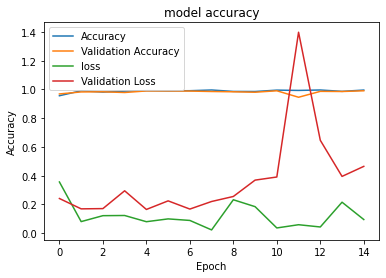

In [15]:
import matplotlib.pyplot as plt
plt.plot(r.history["accuracy"])
plt.plot(r.history['val_accuracy'])
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

#####7. Testing 

DOG


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


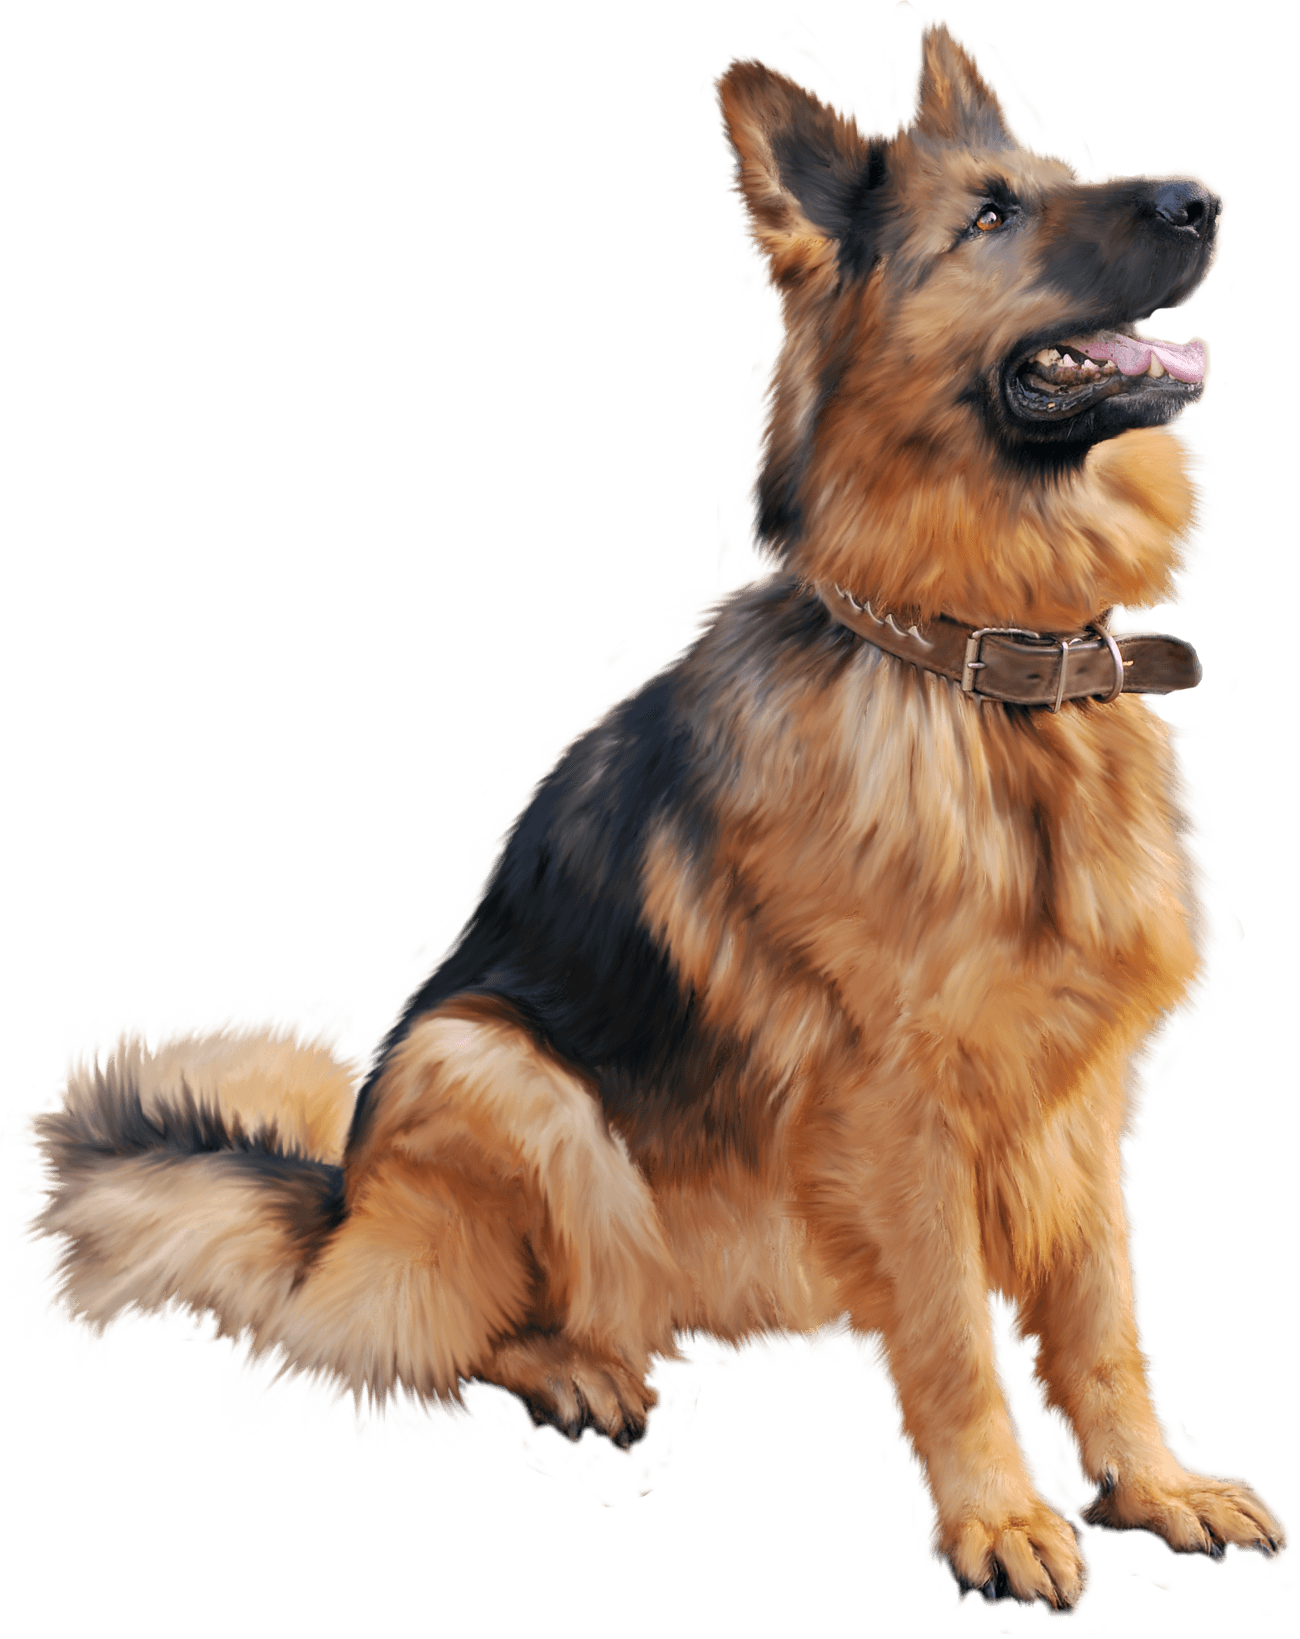

In [21]:
from IPython.display import Image
from keras.preprocessing import image
import tensorflow
img_path = "/content/dog_1.png"##new image path

test_image = image.load_img(img_path, target_size = [224,224])
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
if result==0:
    print("CAT")
else:
    print("DOG")
display(Image(img_path,width = 150, height = 150))
